# Classification with probabilistic deep learning

For regression, the [official tutorial](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html) is very good.

In [1]:
import keras
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line


In [2]:
import silence_tensorflow.auto
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, 
    Flatten, Dropout, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### MNIST data set

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [5]:
x_train[1].shape

(28, 28)

In [6]:
num_classes = 10
input_shape = (28, 28, 1)

In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Fashion MNIST data set

In [9]:
(x_train_1, y_train_1), (x_test_1, y_test_1) = datasets.fashion_mnist.load_data()

In [10]:
x_train_1 = x_train_1.astype("float32") / 255
x_test_1 = x_test_1.astype("float32") / 255
x_train_1 = np.expand_dims(x_train_1, -1)
x_test_1 = np.expand_dims(x_test_1, -1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Dataset comparisons

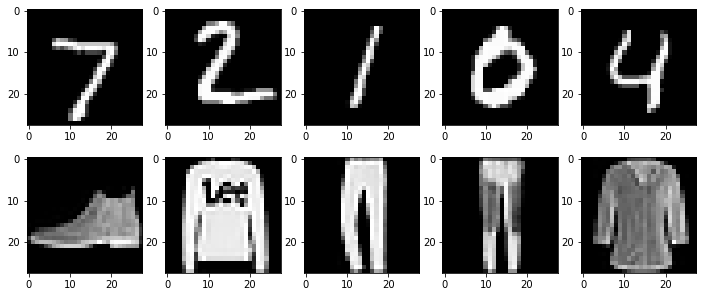

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(2):
    for j in range(5):
        if i == 0:
            axes[i,j].imshow(x_test[j], cmap='gray')
        else:
            axes[i,j].imshow(x_test_1[j], cmap='gray')

### Standard model

```python
model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)
```

In [12]:
inputs = Input(shape=input_shape)
hidden = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
hiidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Conv2D(64, kernel_size=(3, 3), activation="relu")(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Flatten()(hidden)
hidden = Dense(64, activation="relu")(hidden)
hidden = Dense(32, activation="relu")(hidden)
outputs = Dense(num_classes, activation="softmax")(hidden)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

In [13]:
batch_size = 128
epochs = 15

In [14]:
hist = model.fit(x_train, y_train, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 verbose=0,
                 validation_split=0.1)

In [15]:
pd.DataFrame([
    hist.history['loss'][-1], 
    hist.history['val_loss'][-1], 
    hist.history['accuracy'][-1],
    hist.history['val_accuracy'][-1]],
    index=['loss', 'val_loss', 'accuracy', 'val_accuracy'],
    columns=['value']
)

,value
loss,0.003705
val_loss,0.053752
accuracy,0.998648
val_accuracy,0.990000


In [16]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0520096910558894
Test accuracy: 0.9873


### Variational inference model

In [17]:
div = lambda q, p, _: tfp.distributions.kl_divergence(q, p)/(x_train.shape[0] * 1.0)

In [18]:
inputs = Input(shape=input_shape)
hidden = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
hiidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Conv2D(64, kernel_size=(3, 3), activation="relu")(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Flatten()(hidden)
hidden = tfp.layers.DenseFlipout(64, activation="relu", kernel_divergence_fn=div)(hidden)
hidden = tfp.layers.DenseFlipout(32, activation="relu", kernel_divergence_fn=div)(hidden)
outputs = tfp.layers.DenseFlipout(num_classes, activation="softmax", 
                                  kernel_divergence_fn=div)(hidden)

model_vi = Model(inputs=inputs, outputs=outputs)
model_vi.compile(loss="categorical_crossentropy",             
                 optimizer="adam", 
                 metrics=["accuracy"])

In [19]:
batch_size = 128
epochs = 150

In [20]:
hist_vi = model_vi.fit(x_train, y_train, 
                       batch_size=batch_size, 
                       epochs=epochs, 
                       verbose=0,
                       validation_split=0.1)

In [21]:
pd.DataFrame([
    hist_vi.history['loss'][-1], 
    hist_vi.history['val_loss'][-1], 
    hist_vi.history['accuracy'][-1],
    hist_vi.history['val_accuracy'][-1]],
    index=['loss', 'val_loss', 'accuracy', 'val_accuracy'],
    columns=['value']
)

,value
loss,0.117491
val_loss,0.128742
accuracy,0.986778
val_accuracy,0.985000


In [22]:
score = model_vi.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1308649484395981
Test accuracy: 0.9832


### Monte Carlo dropout model

In [23]:
p = 0.3
inputs = Input(shape=input_shape)
hidden = Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
hidden = Dropout(p)(hidden)
hiidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Dropout(p)(hidden)
hidden = Conv2D(64, kernel_size=(3, 3), activation="relu")(hidden)
hidden = Dropout(p)(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Dropout(p)(hidden)
hidden = Flatten()(hidden)
hidden = Dense(64, activation="relu")(hidden)
hidden = Dropout(p)(hidden)
hidden = Dense(32, activation="relu")(hidden)
hidden = Dropout(p)(hidden)
outputs = Dense(num_classes, activation="softmax")(hidden)
outputs = Dense(num_classes, activation="softmax")(hidden)
model_mc = Model(inputs=inputs, outputs=outputs)
model_mc.compile(loss="categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])

In [24]:
batch_size = 128
epochs = 150

In [25]:
hist_mc = model_mc.fit(x_train, y_train, 
                       batch_size=batch_size, 
                       epochs=epochs, 
                       verbose=0,
                       validation_split=0.1)

In [26]:
pd.DataFrame([
    hist_mc.history['loss'][-1], 
    hist_mc.history['val_loss'][-1], 
    hist_mc.history['accuracy'][-1],
    hist_mc.history['val_accuracy'][-1]],
    index=['loss', 'val_loss', 'accuracy', 'val_accuracy'],
    columns=['value']
)

,value
loss,0.017371
val_loss,0.038209
accuracy,0.994944
val_accuracy,0.993333


In [27]:
score = model_mc.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03432575999929436
Test accuracy: 0.9923


### Uncertainty for unseen but *known* samples

In [28]:
runs = 100

In [29]:
pred = np.hstack([model.predict(x_test[:5]) for i in range(runs)])
pred = pred.reshape(-1, runs, num_classes)
pred_vi = np.hstack([model_vi.predict(x_test[:5]) for i in range(runs)])
pred_vi = pred_vi.reshape(-1, runs, num_classes)
pred_mc = np.hstack([model_mc.predict(x_test[:5]) for i in range(runs)])
pred_mc = pred_mc.reshape(-1, runs, num_classes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

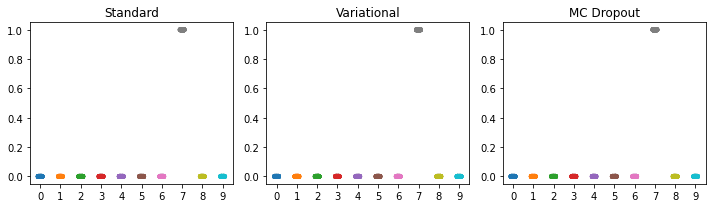

In [30]:
k = 0
fig, axes = plt.subplots(1,3,figsize=(10,3))
sns.stripplot(data=pred[k, :, :], ax=axes[0])
axes[0].set_title('Standard')
sns.stripplot(data=pred_vi[k, :, :], ax=axes[1])
axes[1].set_title('Variational')
sns.stripplot(data=pred_mc[k, :, :], ax=axes[2])
axes[2].set_title('MC Dropout')
plt.tight_layout()
plt.tight_layout()
pass

### Uncertainty for unseen and *unknown* samples

In [31]:
runs = 100

In [32]:
pred = np.hstack([model.predict(x_test_1[:5]) for i in range(runs)])
pred = pred.reshape(-1, runs, num_classes)
pred_vi = np.hstack([model_vi.predict(x_test_1[:5]) for i in range(runs)])
pred_vi = pred_vi.reshape(-1, runs, num_classes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])

In [34]:
pred_mc = np.hstack([model_mc_pred(x_test_1[:5]) for i in range(runs)])
pred_mc = pred_mc.reshape(-1, runs, num_classes)

<IPython.core.display.Javascript object>

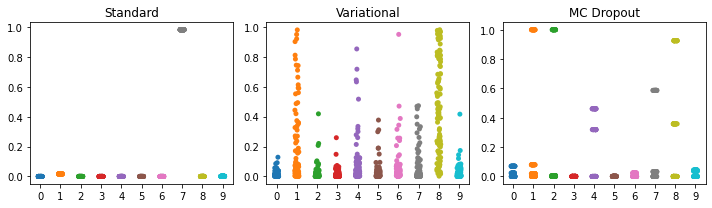

In [35]:
k = 3
fig, axes = plt.subplots(1,3,figsize=(10,3))
sns.stripplot(data=pred[k, :, :], ax=axes[0])
axes[0].set_title('Standard')
sns.stripplot(data=pred_vi[k, :, :], ax=axes[1])
axes[1].set_title('Variational')
sns.stripplot(data=pred_mc[k, :, :], ax=axes[2])
axes[2].set_title('MC Dropout')
plt.tight_layout()
pass